## General Workflow

### 1) Identifying Business Problem
### 2) Data Preprocessing
### 3) Exploratory Data Analysis (EDA)

### 1) Identifying Business Problem

In this case, we're asked to develop a model for an organization that helps non-profit organizations to find donors. This model will be used to predict whether a donor will spend more than or equal to 30€, given that this donor receives a re-activation campaign. The model will be trained based on the previous campaign, and then validated with another data from other campaign.

The model is expected to have a good performance and high interpretability. In addition, we also have to emphasize why does implementing the model is better than random guessing campaign. In the end, the model will be used to predict potential customers for the upcoming campaign, and which customers are the most effective to reach.

### 2) Data Preprocessing

Our data consist of 5 csv files which includes the donor database, the amount of donated, and the selected donors during previous campaign

In [2]:
import pandas as pd
import numpy as np
import datetime

In [ ]:
# Drop 1st Column
donors=pd.read_csv("./data/donors.csv")

donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

donors['province'] = donors['province'].apply(lambda row: 'Antwerp' if row == 'ANTWERP' else row)

gender_dict={'F':1,'M':0,'NaN':969}
# language_dict={'EN':1,'FR':2,'NL':3}
# region_dict={'Brussels':1,'Flanders':2,'Missing':3,'Wallonia':4}
# province_dict={'Antwerp':1,'Brussels':2,'East Flanders':3,'Flemish Brabant':4,
#                 'Hainaut':5,'Liege':6,'Limburg':7,'Luxembourg':8,'Missing':9,
#                 'Namur':10,'Walloon Brabant':11,'West Flanders':12}


# #donors = donors.replace({"province": province_dict, "region": region_dict, "gender": gender_dict,"language":language_dict})
donors = donors.replace({"gender": gender_dict})

donors = pd.get_dummies(donors, columns=['province', 'region', 'language'], drop_first=True)
donors = donors.drop("Unnamed: 0", axis=1)
donors = donors.drop("zipcode", axis=1)
donors.head()

,donorID,gender,dateOfBirth,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,province_Luxembourg,province_Missing,province_Namur,province_Walloon Brabant,province_West Flanders,region_Flanders,region_Missing,region_Wallonia,language_FR,language_NL
0,100001,1.0,1967-12-24,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
1,100002,0.0,1952-01-14,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2,100003,0.0,1986-12-23,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,100004,1.0,1952-03-29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,100005,1.0,1986-06-25,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
campaigns=pd.read_csv("./Data/campaigns.csv",delimiter=";")

for i in range(0,len(campaigns)):
    campaigns.iloc[i,2]=campaigns.iloc[i,2].replace('\u202f','')

for i in range(0,len(campaigns)):
    campaigns.iloc[i,3]=campaigns.iloc[i,3].replace('\xa0€','')

for i in range(0,len(campaigns)):
    campaigns.iloc[i,3]=campaigns.iloc[i,3].replace(',','.')

campaigns['date']=pd.to_datetime(campaigns['date'])
campaigns['lettersSent']=campaigns['lettersSent'].astype(int)
campaigns['lettersSent']=campaigns['lettersSent'].astype(float)
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,2004-12-13,6873.0,0.17
1,154,2005-01-01,7656.0,0.30
2,180,2005-01-18,9933.0,0.20
3,433,2005-01-29,7448.0,0.59
4,476,2005-12-02,6605.0,0.51


In [ ]:
gifts=pd.read_csv("./Data/gifts.csv")
#cleaning gift
# Change date into datetime object
gifts['date'] = pd.to_datetime(gifts['date'])
#
gifts['amount'] = gifts['amount'].str.replace(',', '.')
#
gifts['amount'] = gifts['amount'].astype('float')
#
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date
0,0,100001,NaN,12.39,2004-03-23
1,1,100001,1577.0,12.39,2007-10-11
2,2,100001,1634.0,6.69,2007-12-28
3,3,100001,1778.0,24.79,2008-06-14
4,4,100001,1808.0,7.44,2008-07-09


In [ ]:
gifts[gifts['campaignID'].notnull()]


,Unnamed: 0,donorID,campaignID,amount,date
1,1,100001,1577.0,12.39,2007-10-11
2,2,100001,1634.0,6.69,2007-12-28
3,3,100001,1778.0,24.79,2008-06-14
4,4,100001,1808.0,7.44,2008-07-09
5,5,100001,1933.0,24.79,2008-12-01
...,...,...,...,...,...
216589,216589,265584,6169.0,300.00,2018-09-23
216590,216590,281770,6169.0,30.00,2018-09-08
216591,216591,317880,6169.0,157.50,2018-09-12
216592,216592,480980,6169.0,36.00,2018-09-12


In [ ]:
#
def agg_A(tr):
    tr['total_donated_during_dv'] = tr['amount'].sum()
    return tr
#
gift_6169=gifts[gifts['campaignID'] == 6169]
#
gift_6169 = gift_6169.groupby(by='donorID').apply(agg_A)
#
gift_6169=gift_6169.drop(['campaignID','Unnamed: 0','amount','date'],axis=1)
#
gift_6169.head()

,donorID,total_donated_during_dv
132,100023,15.0
705,100126,123.0
1151,100253,120.0
1362,100279,75.0
1804,100320,135.0


In [ ]:
#
gift_7244=gifts[gifts['campaignID'] == 7244]
#
gift_7244 = gift_7244.groupby(by='donorID').apply(agg_A)
#
gift_7244=gift_7244.drop(['campaignID','Unnamed: 0','amount','date'],axis=1)
#
gift_7244.head()

,donorID,total_donated_during_dv
5828,100724,40.0
7527,100896,10.0
8314,100964,100.0
9269,101066,60.0
9316,101069,80.0


In [ ]:
selection_6169=pd.read_csv("./Data/selection campaign 6169.csv")
selection_7244=pd.read_csv("./Data/selection campaign 7244.csv")
selection_7362=pd.read_csv("./Data/new_campaign_selection.csv")

In [ ]:
#duration of data gadering
iv_period = 365
# dayes befor starting the data gadering
in_between_period = 30
# start and end dates of campaign 6169
date_campaign_6169 = datetime.datetime(2018, 9, 4)
end_period_6169 = date_campaign_6169 - datetime.timedelta(days = in_between_period)
start_period_6169 = end_period_6169 - datetime.timedelta(days = iv_period)
# start and end dates of campaign 7244
date_campaign_7244 = datetime.datetime(2019, 6, 18)
end_period_7244 = date_campaign_7244 - datetime.timedelta(days = in_between_period)
start_period_7244 = end_period_7244 - datetime.timedelta(days = iv_period)
# start and end dates of campaign 7362
date_campaign_7362 = datetime.datetime(2020, 2, 1)
end_period_7362 = date_campaign_7362 - datetime.timedelta(days = in_between_period)
start_period_7362 = end_period_7362 - datetime.timedelta(days = iv_period)


## 6169 Base Table

In [ ]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    out_camp=tr.loc[tr['campaignID'].isna()]
    tr['freq_out_campaign']=out_camp['amount'].count()
    tr['amount_out_campaign']=out_camp['amount'].sum()
    in_camp=tr.loc[tr['campaignID'].notnull()]
    tr['freq_in_campaign']= in_camp['amount'].count()
    tr['amount_in_campaign']=in_camp['amount'].sum()
    date=start_period_6169
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount'],axis=1)
    return tr

gift_till_6169=gifts[gifts['date'] <= start_period_6169]
gift_till_6169=gift_till_6169.drop(['Unnamed: 0'],axis=1)
gift_till_6169 = gift_till_6169.groupby(by='donorID').apply(agg_Till)
gift_till_6169 = gift_till_6169.drop_duplicates(subset=['donorID'])
gift_till_6169=gift_till_6169.drop(['campaignID'],axis=1)

gift_till_6169.head()

,donorID,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years
0,100001,12,178.49,1,12.39,11,166.10,0.0,0
12,100002,1,20.00,0,0.00,1,20.00,20.0,1
13,100003,1,5.00,0,0.00,1,5.00,5.0,1
25,100004,26,716.22,1,24.79,25,691.43,0.0,0
51,100005,3,9.96,0,0.00,3,9.96,5.0,1


In [11]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    out_camp=tr.loc[tr['campaignID'].isna()]
    tr['freq_out_campaign']=out_camp['amount'].count()
    tr['amount_out_campaign']=out_camp['amount'].sum()
    in_camp=tr.loc[tr['campaignID'].notnull()]
    tr['freq_in_campaign']= in_camp['amount'].count()
    tr['amount_in_campaign']=in_camp['amount'].sum()
    date=start_period_7244
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount','campaignID'],axis=1)
    return tr

gift_till_7244=gifts[gifts['date'] <= start_period_7244]
gift_till_7244=gift_till_7244.drop(['Unnamed: 0'],axis=1)
gift_till_7244 = gift_till_7244.groupby(by='donorID').apply(agg_Till)
gift_till_7244 = gift_till_7244.drop_duplicates(subset=['donorID'])


gift_till_7244.head()

,donorID,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years
0,100001,12,178.49,1,12.39,11,166.10,0.0,0
12,100002,1,20.00,0,0.00,1,20.00,0.0,0
13,100003,3,11.00,0,0.00,3,11.00,11.0,3
25,100004,26,716.22,1,24.79,25,691.43,0.0,0
51,100005,3,9.96,0,0.00,3,9.96,5.0,1


In [12]:
gift_till_7244

,donorID,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years
0,100001,12,178.49,1,12.39,11,166.10,0.0,0
12,100002,1,20.00,0,0.00,1,20.00,0.0,0
13,100003,3,11.00,0,0.00,3,11.00,11.0,3
25,100004,26,716.22,1,24.79,25,691.43,0.0,0
51,100005,3,9.96,0,0.00,3,9.96,5.0,1
...,...,...,...,...,...,...,...,...,...
216566,144687,1,10.00,0,0.00,1,10.00,10.0,1
216567,144688,7,48.56,1,5.00,6,43.56,15.0,1
216574,144689,1,24.79,0,0.00,1,24.79,0.0,0
216578,144690,1,40.00,0,0.00,1,40.00,0.0,0


In [13]:
def agg_Till(tr):
    
    tr['total_freq_till_now'] = tr['amount'].count()
    tr['total_amount_till_now'] = tr['amount'].sum()
    out_camp=tr.loc[tr['campaignID'].isna()]
    tr['freq_out_campaign']=out_camp['amount'].count()
    tr['amount_out_campaign']=out_camp['amount'].sum()
    in_camp=tr.loc[tr['campaignID'].notnull()]
    tr['freq_in_campaign']= in_camp['amount'].count()
    tr['amount_in_campaign']=in_camp['amount'].sum()
    date=start_period_7362
    Last3_years = tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*365))]
    tr['total_amount_till_last_3_years'] = Last3_years['amount'].sum()
    tr['total_freq_till_last_3_years'] = Last3_years['amount'].count()

    tr = tr.drop(['date','amount','campaignID'],axis=1)
    return tr

gift_till_7362=gifts[gifts['date'] <= start_period_7362]
gift_till_7362 = gift_till_7362.groupby(by='donorID').apply(agg_Till)
gift_till_7362 = gift_till_7362.drop_duplicates(subset=['donorID'])


gift_till_7362.head()

In [ ]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_5434 = tr.loc[(tr['campaignID'] == 5434)]
    tr['C1'] = c_5434['amount'].sum()

    c_5397 = tr.loc[(tr['campaignID'] == 5397)]
    tr['C2'] = c_5397['amount'].sum()

    c_5359 = tr.loc[(tr['campaignID'] == 5359)]
    tr['C3'] = c_5359['amount'].sum()

    c_5326 = tr.loc[(tr['campaignID'] == 5326)]
    tr['C4'] = c_5326['amount'].sum()

    c_5316 = tr.loc[(tr['campaignID'] == 5316)]
    tr['C5'] = c_5316['amount'].sum()

    c_5296 = tr.loc[(tr['campaignID'] == 5296)]
    tr['C6'] = c_5296['amount'].sum()

    c_5270 = tr.loc[(tr['campaignID'] == 5270)]
    tr['C7'] = c_5270['amount'].sum()

    c_5267 = tr.loc[(tr['campaignID'] == 5267)]
    tr['C8'] = c_5267['amount'].sum()

    c_5232 = tr.loc[(tr['campaignID'] == 5232)]
    tr['C9'] = c_5232['amount'].sum()

    c_5213 = tr.loc[(tr['campaignID'] == 5213)]
    tr['C10'] = c_5213['amount'].sum()

    c_5186 = tr.loc[(tr['campaignID'] == 5186)]
    tr['C11'] = c_5186['amount'].sum()

    c_5175 = tr.loc[(tr['campaignID'] == 5175)]
    tr['C12'] = c_5175['amount'].sum()

    c_5104 = tr.loc[(tr['campaignID'] == 5104)]
    tr['C13'] = c_5104['amount'].sum()
    date=start_period_6169
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
#
gift_base_6169 = gifts[(gifts['date'] >= start_period_6169) &  (gifts['date'] <= end_period_6169)]
#
gift_base_6169 = gift_base_6169.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_6169 = gift_base_6169.drop_duplicates(subset=['donorID'])
#
gift_base_6169['Recency_dono'] = end_period_6169 - gift_base_6169['last_date_dono']
#
gift_base_6169['Recency_dono'] = gift_base_6169['Recency_dono'].dt.days
#
gift_base_6169=gift_base_6169.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 6169 Campaign Data
gift_base_6169 = pd.merge(selection_6169,gift_base_6169, how='left', on='donorID')
# Merge with dv table
gift_base_6169 = pd.merge(gift_base_6169, gift_6169, how='left', on='donorID')
# Merge with donor database
gift_base_6169 = pd.merge(gift_base_6169, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
gift_base_6169 = pd.merge(gift_base_6169, gift_till_6169, how='left', on='donorID')
#________________________________________
# Target Variable
gift_base_6169['donated_more_than30_duringdv'] = gift_base_6169['total_donated_during_dv'].apply(
                                                                lambda row: 1 if row >= 30 else 0)
#
gift_base_6169['Age'] = gift_base_6169['dateOfBirth'].apply(lambda row:
                 date_campaign_6169.year - row.year -((date_campaign_6169.month, date_campaign_6169.day) < (row.month, row.day) ))
#
#gift_base_6169=gift_base_6169.drop(['Unnamed: 0','total_donated_during_dv','dateOfBirth'],axis=1)
#filling nans
# gift_base_6169['total_donated'] = gift_base_6169['total_donated'].fillna(0)#gift_base_6169['total_donated'].mean())
# gift_base_6169['Recency_dono'] = gift_base_6169['Recency_dono'].fillna(0)#gift_base_6169['Recency_dono'].mean())
# gift_base_6169['frequency_donor'] = gift_base_6169['frequency_donor'].fillna(0)#gift_base_6169['frequency_donor'].median())
#save base tabel 6169 
gift_base_6169.to_csv('./data/gift_base_6169.csv')
#showing Data
gift_base_6169.head()

KeyError: "['Unnamed: 0'] not found in axis"

In [15]:
gift_base_6169.to_csv('./data/gift_base_6169.csv')
#showing Data
gift_base_6169.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,donated_more_than30_duringdv,Age
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,178.49,1.0,12.39,11.0,166.10,0.0,0.0,0,50.0
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,20.00,0.0,0.00,1.0,20.00,20.0,1.0,0,66.0
2,100004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,26.0,716.22,1.0,24.79,25.0,691.43,0.0,0.0,0,66.0
3,100008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,124.37,0.0,0.00,3.0,124.37,0.0,0.0,0,81.0
4,100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,326.78,0.0,0.00,19.0,326.78,0.0,0.0,0,86.0


In [16]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_7229 = tr.loc[(tr['campaignID'] == 7229)]
    tr['C1'] = c_7229['amount'].sum()

    c_7212 = tr.loc[(tr['campaignID'] == 7212)]
    tr['C2'] = c_7212['amount'].sum()

    c_7199 = tr.loc[(tr['campaignID'] == 7199)]
    tr['C3'] = c_7199['amount'].sum()

    c_7108 = tr.loc[(tr['campaignID'] == 7108)]
    tr['C4'] = c_7108['amount'].sum()

    c_7090 = tr.loc[(tr['campaignID'] == 7090)]
    tr['C5'] = c_7090['amount'].sum()

    c_7074 = tr.loc[(tr['campaignID'] == 7074)]
    tr['C6'] = c_7074['amount'].sum()

    c_7064 = tr.loc[(tr['campaignID'] == 7064)]
    tr['C7'] = c_7064['amount'].sum()

    c_7059 = tr.loc[(tr['campaignID'] == 7059)]
    tr['C8'] = c_7059['amount'].sum()

    c_7037 = tr.loc[(tr['campaignID'] == 7037)]
    tr['C9'] = c_7037['amount'].sum()

    c_7005 = tr.loc[(tr['campaignID'] == 7005)]
    tr['C10'] = c_7005['amount'].sum()

    c_7002 = tr.loc[(tr['campaignID'] == 7002)]
    tr['C11'] = c_7002['amount'].sum()

    c_6959 = tr.loc[(tr['campaignID'] == 6959)]
    tr['C12'] = c_6959['amount'].sum()

    c_6958 = tr.loc[(tr['campaignID'] == 6958)]
    tr['C13'] = c_6958['amount'].sum()

    date=start_period_7244
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
gift_base_7244 = gifts[(gifts['date'] >= start_period_7244) &  (gifts['date'] <= end_period_7244)]
#
gift_base_7244=gift_base_7244.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_7244 = gift_base_7244.drop_duplicates(subset=['donorID'])
#
gift_base_7244['Recency_dono'] = end_period_7244 - gift_base_7244['last_date_dono']
#
gift_base_7244['Recency_dono'] = gift_base_7244['Recency_dono'].dt.days
#
gift_base_7244=gift_base_7244.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 7244 Campaign Data
gift_base_7244 = pd.merge(selection_7244,gift_base_7244, how='left', on='donorID')
# # Merge with iv table
gift_base_7244 = pd.merge(gift_base_7244, gift_7244, how='left', on='donorID')
# Merge with donor database
gift_base_7244 = pd.merge(gift_base_7244, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
gift_base_7244 = pd.merge(gift_base_7244, gift_till_7244, how='left', on='donorID')
#________________________________________
# Target Variable
gift_base_7244['donated_more_than30_duringdv'] = gift_base_7244['total_donated_during_dv'].apply(
                                                                lambda row: 1 if row >= 30 else 0)
#
gift_base_7244['Age'] = gift_base_7244['dateOfBirth'].apply(lambda row:
                 date_campaign_7244.year - row.year -((date_campaign_7244.month, date_campaign_7244.day) < (row.month, row.day) ))
#
#gift_base_7244=gift_base_7244.drop(['Unnamed: 0','total_donated_during_dv','dateOfBirth'],axis=1)
#filling nans
# gift_base_7244['total_donated'] = gift_base_7244['total_donated'].fillna(0)#gift_base_7244['total_donated'].mean())
# gift_base_7244['Recency_dono'] = gift_base_7244['Recency_dono'].fillna(0)#gift_base_7244['Recency_dono'].mean())
# gift_base_7244['frequency_donor'] = gift_base_7244['frequency_donor'].fillna(0)#gift_base_7244['frequency_donor'].median())
#save base tabel 7244
gift_base_7244.to_csv('./data/gift_base_7244.csv')
#showing Data
gift_base_7244.head()

,donorID,campaignID,frequency_donor,total_donated,C1,C2,C3,C4,C5,C6,...,total_freq_till_now,total_amount_till_now,freq_out_campaign,amount_out_campaign,freq_in_campaign,amount_in_campaign,total_amount_till_last_3_years,total_freq_till_last_3_years,donated_more_than30_duringdv,Age
0,100001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,178.49,1.0,12.39,11.0,166.10,0.0,0.0,0,51
1,100002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,20.00,0.0,0.00,1.0,20.00,0.0,0.0,0,67
2,100008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,124.37,0.0,0.00,3.0,124.37,0.0,0.0,0,81
3,100009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,326.78,0.0,0.00,19.0,326.78,0.0,0.0,0,87
4,100010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,40.00,0.0,0.00,1.0,40.00,0.0,0.0,0,36


In [ ]:
#
def agg_B(tr):
    tr['last_date_dono'] = tr['date'].max()
    tr['frequency_donor'] = tr['amount'].count()
    tr['total_donated'] = tr['amount'].sum()
    c_7536 = tr.loc[(tr['campaignID'] == 7536)]
    tr['C1'] = c_7536['amount'].sum()

    c_7519 = tr.loc[(tr['campaignID'] == 7519)]
    tr['C2'] = c_7519['amount'].sum()

    c_7505 = tr.loc[(tr['campaignID'] == 7505)]
    tr['C3'] = c_7505['amount'].sum()

    c_7503 = tr.loc[(tr['campaignID'] == 7503)]
    tr['C4'] = c_7503['amount'].sum()

    c_7494 = tr.loc[(tr['campaignID'] == 7494)]
    tr['C5'] = c_7494['amount'].sum()

    c_7408 = tr.loc[(tr['campaignID'] == 7408)]
    tr['C6'] = c_7408['amount'].sum()

    c_7395 = tr.loc[(tr['campaignID'] == 7395)]
    tr['C7'] = c_7395['amount'].sum()

    c_7356 = tr.loc[(tr['campaignID'] == 7356)]
    tr['C8'] = c_7356['amount'].sum()

    c_7346 = tr.loc[(tr['campaignID'] == 7346)]
    tr['C9'] = c_7346['amount'].sum()

    c_7335 = tr.loc[(tr['campaignID'] == 7335)]
    tr['C10'] = c_7335['amount'].sum()

    c_7330 = tr.loc[(tr['campaignID'] == 7330)]
    tr['C11'] = c_7330['amount'].sum()

    c_7276 = tr.loc[(tr['campaignID'] == 7276)]
    tr['C12'] = c_7276['amount'].sum()

    c_7244 = tr.loc[(tr['campaignID'] == 7244)]
    tr['C13'] = c_7244['amount'].sum()

    date=start_period_7362
    month_1= tr.loc[(tr['date'] > date- datetime.timedelta(days = 30))]
    tr['total_amount_1_month'] = month_1['amount'].sum()
    tr['total_freq_1_month'] = month_1['amount'].count()
    month_2= tr.loc[(tr['date'] > date- datetime.timedelta(days = 2*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 30))]
    tr['total_amount_2_month'] = month_2['amount'].sum()
    tr['total_freq_2_month'] = month_2['amount'].count()
    month_3= tr.loc[(tr['date'] > date- datetime.timedelta(days = 3*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 2*30))]
    tr['total_amount_3_month'] = month_3['amount'].sum()
    tr['total_freq_3_month'] = month_3['amount'].count()
    month_4= tr.loc[(tr['date'] > date- datetime.timedelta(days = 4*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 3*30))]
    tr['total_amount_4_month'] = month_4['amount'].sum()
    tr['total_freq_4_month'] = month_4['amount'].count()
    month_5= tr.loc[(tr['date'] > date- datetime.timedelta(days = 5*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 4*30))]
    tr['total_amount_5_month'] = month_5['amount'].sum()
    tr['total_freq_5_month'] = month_5['amount'].count()
    month_6= tr.loc[(tr['date'] > date- datetime.timedelta(days = 6*30))&
                     (tr['date'] <= date- datetime.timedelta(days = 5*30))]
    tr['total_amount_6_month'] = month_6['amount'].sum()
    tr['total_freq_6_month'] = month_6['amount'].count()
    
    tr = tr.drop(['date','amount','Unnamed: 0'],axis=1)
    return tr
gift_base_7362 = gifts[(gifts['date'] >= start_period_7362) &  (gifts['date'] <= end_period_7362)]
#
gift_base_7362=gift_base_7362.groupby(by='donorID').apply(agg_B)
# remove duplicate rows
gift_base_7362 = gift_base_7362.drop_duplicates(subset=['donorID'])
#
gift_base_7362['Recency_dono'] = end_period_7362 - gift_base_7362['last_date_dono']
#
gift_base_7362['Recency_dono'] = gift_base_7362['Recency_dono'].dt.days
#
gift_base_7362=gift_base_7362.drop(['last_date_dono'],axis=1)
# Build Base Table Based On the 7362 Campaign Data
gift_base_7362 = pd.merge(selection_7362,gift_base_7362, how='left', on='donorID')
# Merge with donor database
gift_base_7362 = pd.merge(gift_base_7362, donors, how='left', on='donorID')
#_______Hadi added this merge_ U can check it guys :)
gift_base_7362 = pd.merge(gift_base_7362, gift_till_7362, how='left', on='donorID')
#________________________________________
gift_base_7362['Age'] = gift_base_7362['dateOfBirth'].apply(lambda row:
                 date_campaign_7362.year - row.year -((date_campaign_7362.month, date_campaign_7362.day) < (row.month, row.day) ))
#
gift_base_7362=gift_base_7362.drop(['dateOfBirth'],axis=1)
#filling nans
# gift_base_7362['total_donated'] = gift_base_7362['total_donated'].fillna(0)#gift_base_7362['total_donated'].mean())
# gift_base_7362['Recency_dono'] = gift_base_7362['Recency_dono'].fillna(0)#gift_base_7362['Recency_dono'].mean())
# gift_base_7362['frequency_donor'] = gift_base_7362['frequency_donor'].fillna(0)#gift_base_7362['frequency_donor'].median())
#save base tabel 7362
gift_base_7362.to_csv('./data/gift_base_7362.csv')
#showing Data
gift_base_7362.head()

In [204]:
plot_6169=pd.read_csv("./data/plot_6169.csv")

plot_7244=pd.read_csv("./data/plot_7244.csv")

plot_7362=pd.read_csv("./data/plot_7362.csv")

In [205]:
plot_6169['Age_group']=plot_6169['Age']//10*10
plot_7244['Age_group']=plot_7244['Age']//10*10
plot_7362['Age_group']=plot_7362['Age']//10*10

plot_6169.groupby('Age_group')['Age_group'].count()

Age_group
20.0     3984
30.0     7446
40.0     8340
50.0     6707
60.0     4399
70.0     2502
80.0     1130
90.0      365
120.0       1
Name: Age_group, dtype: int64

In [206]:
data={'Campaign No':[6169,7244,7362]}
summary=pd.DataFrame(data)
summary['Total Frequency']=[plot_6169.frequency_donor.sum(),
                            plot_7244.frequency_donor.sum(),
                            plot_7362.frequency_donor.sum()]
summary['Total Amount']=[plot_6169.total_donated.sum(),
                        plot_7244.total_donated.sum(),
                        plot_7362.total_donated.sum()]
summary['Average Recency']=[plot_6169.Recency_dono.mean(),
                            plot_7244.Recency_dono.mean(),
                            plot_7362.Recency_dono.mean()]
summary['Number of Woman']=[plot_6169[plot_6169['gender']==1].Recency_dono.count(),
                        plot_7244[plot_7244['gender']==1].Recency_dono.count(),
                        plot_7362[plot_7362['gender']==1].Recency_dono.count()]
summary['Number of Man']=[plot_6169[plot_6169['gender']==0].Recency_dono.count(),
                        plot_7244[plot_7244['gender']==0].Recency_dono.count(),
                        plot_7362[plot_7362['gender']==0].Recency_dono.count()]
summary['Region Brussel']=[plot_6169[plot_6169['region']==1].Recency_dono.count(),
                        plot_7244[plot_7244['region']==1].Recency_dono.count(),
                        plot_7362[plot_7362['region']==1].Recency_dono.count()] 
summary['Region Flanders']=[plot_6169[plot_6169['region']==2].Recency_dono.count(),
                        plot_7244[plot_7244['region']==2].Recency_dono.count(),
                        plot_7362[plot_7362['region']==2].Recency_dono.count()]      
summary['Region Wallonia']=[plot_6169[plot_6169['region']==4].Recency_dono.count(),
                        plot_7244[plot_7244['region']==4].Recency_dono.count(),
                        plot_7362[plot_7362['region']==4].Recency_dono.count()]  
summary['Age Group 10']=[plot_6169[plot_6169['Age_group']==10].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==10].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==10].Recency_dono.count()]
summary['Age Group 20']=[plot_6169[plot_6169['Age_group']==20].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==20].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==20].Recency_dono.count()] 
summary['Age Group 30']=[plot_6169[plot_6169['Age_group']==30].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==30].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==30].Recency_dono.count()]
summary['Age Group 40']=[plot_6169[plot_6169['Age_group']==40].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==40].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==40].Recency_dono.count()] 
summary['Age Group 50']=[plot_6169[plot_6169['Age_group']==50].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==50].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==50].Recency_dono.count()] 
summary['Age Group 60']=[plot_6169[plot_6169['Age_group']==60].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==60].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==60].Recency_dono.count()] 
summary['Age Group 70']=[plot_6169[plot_6169['Age_group']==70].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==70].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==70].Recency_dono.count()] 
summary['Age Group 80']=[plot_6169[plot_6169['Age_group']==80].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==80].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==80].Recency_dono.count()] 
summary['Age Group 90']=[plot_6169[plot_6169['Age_group']==90].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==90].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==90].Recency_dono.count()] 
summary['Age Group 100']=[plot_6169[plot_6169['Age_group']==100].Recency_dono.count(),
                        plot_7244[plot_7244['Age_group']==100].Recency_dono.count(),
                        plot_7362[plot_7362['Age_group']==100].Recency_dono.count()]                               
summary['Total Amount out campaign']=[plot_6169.amount_out_campaign.sum(),
                        plot_7244.amount_out_campaign.sum(),
                        plot_7362.amount_out_campaign.sum()]
summary['total freq till last 3 years']=[plot_6169.total_freq_till_last_3_years.sum(),
                        plot_7244.total_freq_till_last_3_years.sum(),
                        plot_7362.total_freq_till_last_3_years.sum()]
summary['total amount till last 3 years']=[plot_6169.total_amount_till_last_3_years.sum(),
                        plot_7244.total_amount_till_last_3_years.sum(),
                        plot_7362.total_amount_till_last_3_years.sum()]
summary['amount_in_campaign']=[plot_6169.amount_in_campaign.sum(),
                        plot_7244.amount_in_campaign.sum(),
                        plot_7362.amount_in_campaign.sum()]
summary['freq_in_campaign']=[plot_6169.freq_in_campaign.sum(),
                        plot_7244.freq_in_campaign.sum(),
                        plot_7362.freq_in_campaign.sum()]
summary['amount_out_campaign']=[plot_6169.amount_out_campaign.sum(),
                        plot_7244.amount_out_campaign.sum(),
                        plot_7362.amount_out_campaign.sum()]
summary['freq_out_campaign']=[plot_6169.freq_out_campaign.sum(),
                        plot_7244.freq_out_campaign.sum(),
                        plot_7362.freq_out_campaign.sum()]
summary['total_amount_till_now']=[plot_6169.total_amount_till_now.sum(),
                        plot_7244.total_amount_till_now.sum(),
                        plot_7362.total_amount_till_now.sum()]
summary['total_freq_till_now']=[plot_6169.total_freq_till_now.sum(),
                        plot_7244.total_freq_till_now.sum(),
                        plot_7362.total_freq_till_now.sum()]


summary

,Campaign No,Total Frequency,Total Amount,Average Recency,Number of Woman,Number of Man,Region Brussel,Region Flanders,Region Wallonia,Age Group 10,...,Age Group 100,Total Amount out campaign,total freq till last 3 years,total amount till last 3 years,amount_in_campaign,freq_in_campaign,amount_out_campaign,freq_out_campaign,total_amount_till_now,total_freq_till_now
0,6169,310.0,6228.570,51.219388,83,113,7,175,14,0,...,0,4.299731e+06,9914.0,239509.715,6.104603e+06,136279.0,4.299731e+06,10868.0,1.040433e+07,147147.0
1,7244,80.0,2723.220,53.640625,27,37,0,59,5,0,...,0,4.220418e+06,3003.0,76734.920,5.209218e+06,100914.0,4.220418e+06,7988.0,9.429636e+06,108902.0
2,7362,1318.0,46059.385,71.601703,539,517,32,944,81,0,...,1,4.221315e+06,12023.0,411005.133,5.810010e+06,119602.0,4.221315e+06,8902.0,1.003132e+07,128504.0


In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

In [207]:
gender_dict={0:"Female",1:"Male"}
language_dict={1:'EN',2:'FR',3:'NL'}
region_dict={1:'Brussels',2:'Flanders',3:'Missing',4:'Wallonia'}
province_dict={1:'Antwerp',2:'Brussels',3:'East Flanders',4:'Flemish Brabant',
                5:'Hainaut',6:'Liege',7:'Limburg',8:'Luxembourg',9:'Missing',
                10:'Namur',11:'Walloon Brabant',12:'West Flanders'}
plot_6169 = plot_6169.replace({"province": province_dict, "region": region_dict, "gender": gender_dict,"language":language_dict})
plot_7244 = plot_7244.replace({"province": province_dict, "region": region_dict, "gender": gender_dict,"language":language_dict})
plot_7362 = plot_7362.replace({"province": province_dict, "region": region_dict, "gender": gender_dict,"language":language_dict})

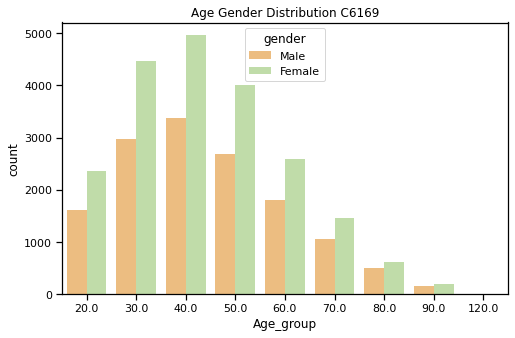

<Figure size 432x288 with 0 Axes>

In [228]:
#gender distribution by age category
fig, ax = plt.subplots()
fig.set_size_inches(8, 5, forward=True)
ax = sns.countplot(x='Age_group', hue='gender', data=plot_6169,palette=("Spectral"))
sns.set_context("notebook")
plt.title("Age Gender Distribution C6169")
plt.show()
#saving the plot
#saving the plot
plt.savefig("./figs/1.Age Gender Distribution C6169.png",dpi=150,format="png")

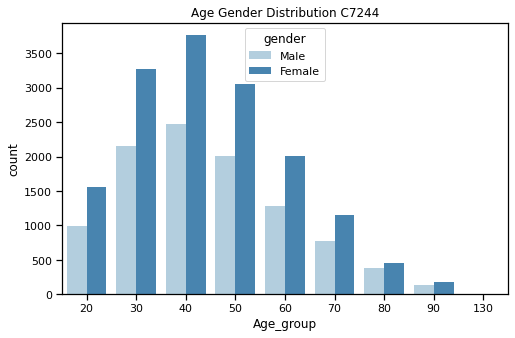

<Figure size 432x288 with 0 Axes>

In [209]:
#gender distribution by age category
fig, ax = plt.subplots()
fig.set_size_inches(8, 5, forward=True)
ax = sns.countplot(x='Age_group', hue='gender', data=plot_7244,palette=("Blues"))
sns.set_context("notebook")
plt.title("Age Gender Distribution C7244")
plt.show()
#saving the plot
plt.savefig("./figs/2.Age Gender Distribution C7244.png",dpi=150,format="png")

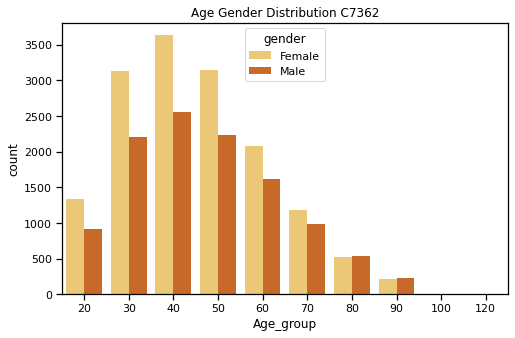

<Figure size 432x288 with 0 Axes>

In [210]:
#gender distribution by age category
fig, ax = plt.subplots()
fig.set_size_inches(8, 5, forward=True)
ax = sns.countplot(x='Age_group', hue='gender', data=plot_7362,palette=("YlOrBr"))
sns.set_context("notebook")
plt.title("Age Gender Distribution C7362")
plt.show()
#saving the plot
plt.savefig("./figs/3.Age Gender Distribution C7362.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


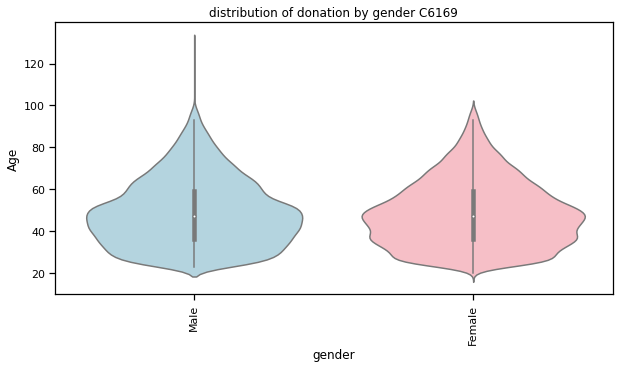

<Figure size 432x288 with 0 Axes>

In [211]:
plt.figure(figsize=(10,5))
sns.violinplot("gender", "Age", data=plot_6169,
               palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("distribution of donation by gender C6169")
plt.show()
#saving the plot
plt.savefig("./figs/4.distribution of donation by gender C6169.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


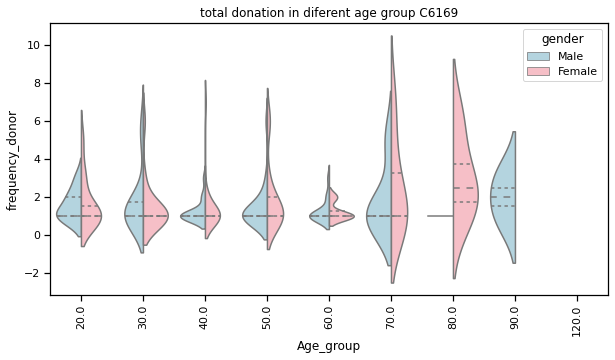

<Figure size 432x288 with 0 Axes>

In [214]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("Age_group", "frequency_donor", hue="gender", data=plot_6169,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent age group C6169")
plt.show()
#saving the plot
plt.savefig("./figs/5.total donation in diferent age group C6169.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


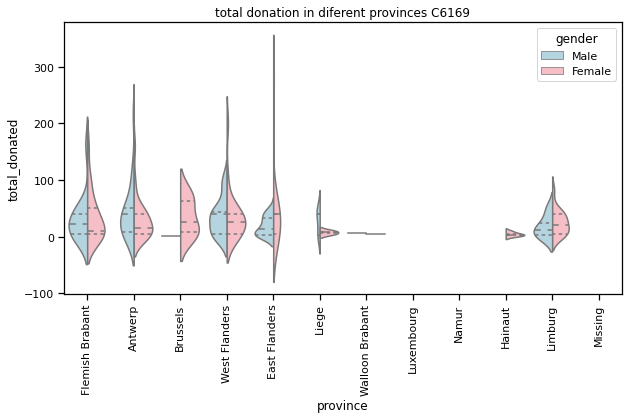

<Figure size 432x288 with 0 Axes>

In [215]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("province", "total_donated", hue="gender", data=plot_6169,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent provinces C6169")
plt.show()
#saving the plot
plt.savefig("./figs/6.total donation in diferent age group C6169.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


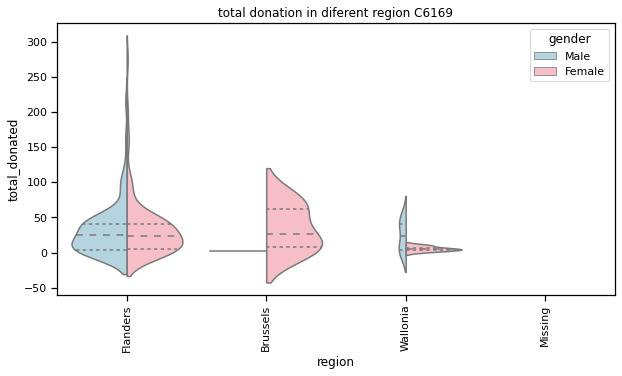

<Figure size 432x288 with 0 Axes>

In [216]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("region", "total_donated", hue="gender", data=plot_6169,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent region C6169")
plt.show()
#saving the plot
plt.savefig("./figs/7.total donation in diferent region C6169.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


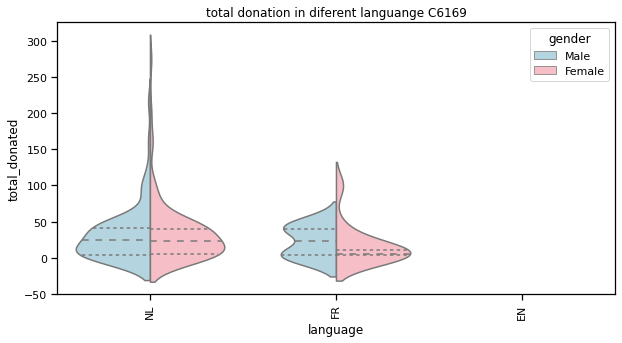

<Figure size 432x288 with 0 Axes>

In [217]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("language", "total_donated", hue="gender", data=plot_6169,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent languange C6169")
plt.show()
#saving the plot
plt.savefig("./figs/8.total donation in diferent languange C6169.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


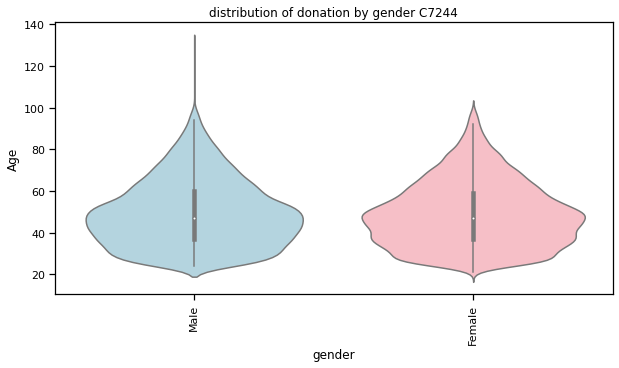

<Figure size 432x288 with 0 Axes>

In [218]:
plt.figure(figsize=(10,5))
sns.violinplot("gender", "Age", data=plot_7244,
               palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("distribution of donation by gender C7244")
plt.show()
#saving the plot
plt.savefig("./figs/9.distribution of donation by gender C7244.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


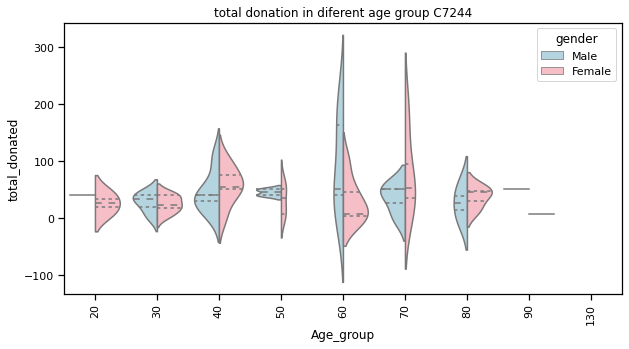

<Figure size 432x288 with 0 Axes>

In [219]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("Age_group", "total_donated", hue="gender", data=plot_7244,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent age group C7244")
plt.show()
#saving the plot
plt.savefig("./figs/10.total donation in diferent age group C7244.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


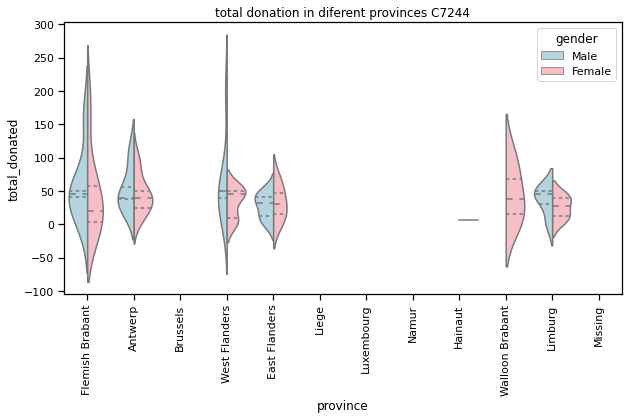

<Figure size 432x288 with 0 Axes>

In [220]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("province", "total_donated", hue="gender", data=plot_7244,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent provinces C7244")
plt.show()
#saving the plot
plt.savefig("./figs/11.total donation in diferent provinces C7244.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


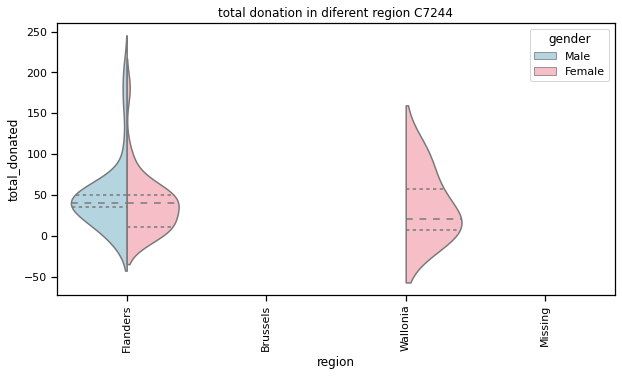

<Figure size 432x288 with 0 Axes>

In [221]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("region", "total_donated", hue="gender", data=plot_7244,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent region C7244")
plt.show()
#saving the plot
plt.savefig("./figs/12.total donation in diferent region C7244.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


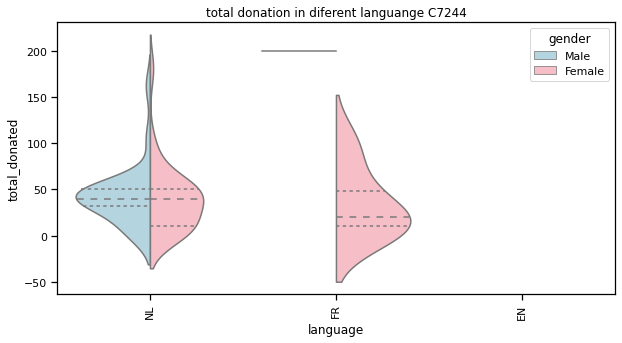

<Figure size 432x288 with 0 Axes>

In [222]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("language", "total_donated", hue="gender", data=plot_7244,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent languange C7244")
plt.show()
#saving the plot
plt.savefig("./figs/13.total donation in diferent languange C7244.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


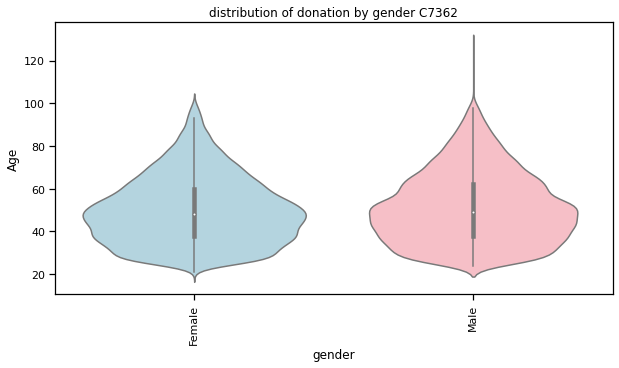

<Figure size 432x288 with 0 Axes>

In [223]:
plt.figure(figsize=(10,5))
sns.violinplot("gender", "Age", data=plot_7362,
               palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("distribution of donation by gender C7362")
plt.show()
#saving the plot
plt.savefig("./figs/14.distribution of donation by gender C7362.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


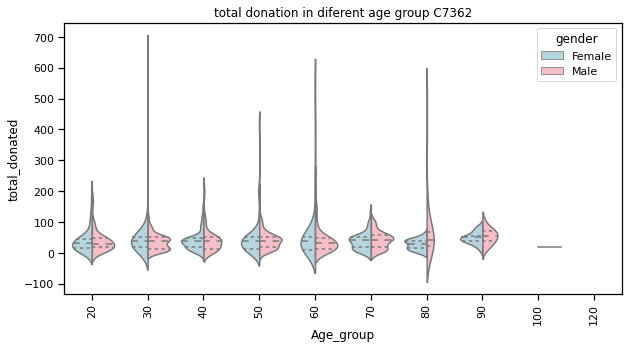

<Figure size 432x288 with 0 Axes>

In [224]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("Age_group", "total_donated", hue="gender", data=plot_7362,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent age group C7362")
plt.show()
#saving the plot
plt.savefig("./figs/15.total donation in diferent age group C7362.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


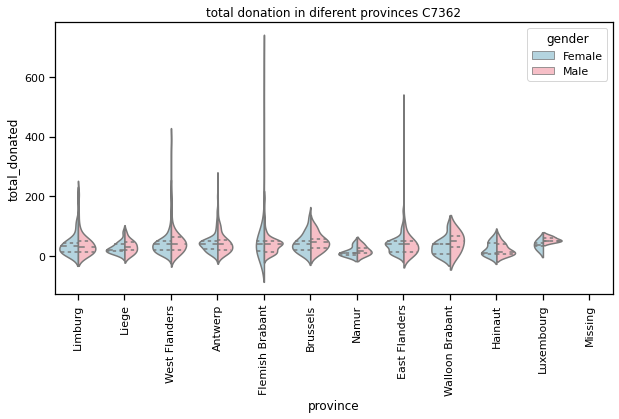

<Figure size 432x288 with 0 Axes>

In [225]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("province", "total_donated", hue="gender", data=plot_7362,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90)
plt.title("total donation in diferent provinces C7362")
plt.show()
#saving the plot
plt.savefig("./figs/16.total donation in diferent provinces C7362.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


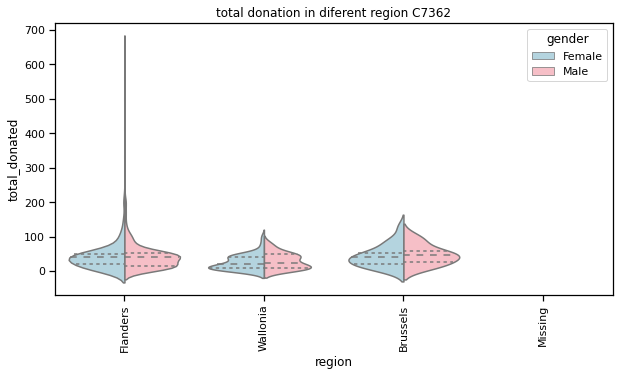

<Figure size 432x288 with 0 Axes>

In [226]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("region", "total_donated", hue="gender", data=plot_7362,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent region C7362")
plt.show()
#saving the plot
plt.savefig("./figs/17.total donation in diferent region C7362.png",dpi=150,format="png")

C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


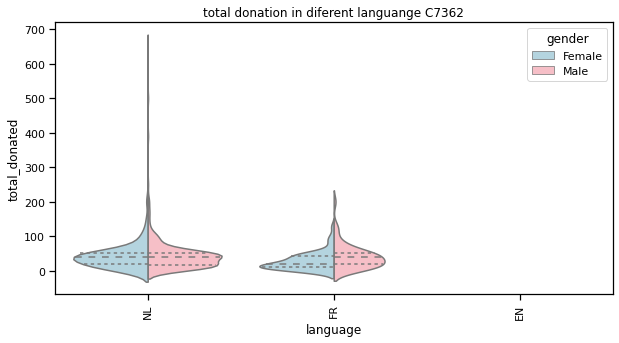

<Figure size 432x288 with 0 Axes>

In [227]:
plt.figure(figsize=(10,5))
with sns.axes_style(style=None):
    sns.violinplot("language", "total_donated", hue="gender", data=plot_7362,
                   split=True, inner="quartile",
                   palette=["lightblue", "lightpink"])
plt.xticks(rotation=90) 
plt.title("total donation in diferent languange C7362")
plt.show()
#saving the plot
plt.savefig("./figs/18.total donation in diferent languange C7362.png",dpi=150,format="png")